# Density and Likelihood

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1dg7ji2/i_need_clarity_on_likelihood_and_probability/).

>  I'm a math graduate and am partially self taught. I am really frustrated with likelihood and probability density, two concepts that I personally think are explained so disastrously that I've been struggling with them for an embarrassingly long time. Here's my current understanding and what I want to understand:
>
> *    probability density is the 'concentration of probability' or probability per unit and the value of the density in any particular interval depends on the density function used. When you integrate the density curve over all outcomes x in X where X is a random variable and x are its realizations then the result should be all the probability or 1.
>
> *    likelihood is the joint probability, in the discrete case, of observing fixed and known data depending on what parameter(s) value we choose. In the continuous case we do not have a nonzero probability of any single value but we do have nonzero probability within some infinitely small interval (containing infinite values?) [x, x+h] and maximizing the likelihood of observing this data is equivalent to maximizing the probability of observing it, which we can do by maximizing the density at x.
>
> My questions are:
>
> Is what I wrote above correct? Probability density and likelihood are not the same thing. But what the precise distinction is in the continuous case is not completely cut and dry to me. [...]

I agree with OP -- these topics are confusing and not always explained well. So let's see what we can do.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/likelihood.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

'utils.py'

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

## Mass

I'll start with a discrete distribution, so we can leave density out of it for now and focus on the difference between a probability mass function (PMF) and a likelihood function.

As an example, suppose we know that a hockey team scores goals at a rate of 3 goals per game on average.
If we model goal scoring as a Poisson process -- which is not a bad model -- the number of goals per game follows a Poisson distribution with parameter `mu=3`.

The PMF of the Poisson distribution tells us the probability of scoring `k` goals in a game, for non-negative values of `k`.

In [4]:
from scipy.stats import poisson

ks = np.arange(12)
ps = poisson.pmf(ks, mu=3)

Here's what it looks like.

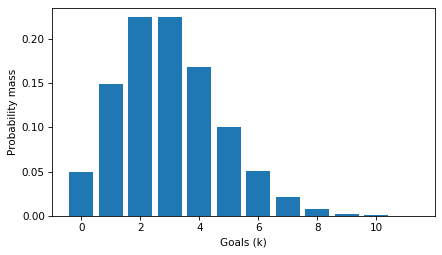

In [5]:
plt.bar(ks, ps)
decorate(xlabel='Goals (k)', ylabel='Probability mass')

The PMF is a function of `k`, with `mu` as a fixed parameter.

The values in the distribution are probability masses, so if we want to know the probability of scoring exactly 5 goals, we can look it up like this.

In [6]:
ps[5]

0.10081881344492458

It's about 10%.

The sum of the `ps` is close to 1.

In [7]:
ps.sum()

0.999928613371026

If we extend the `ks` to infinity, the sum is exactly 1.
So this set of probability masses is a proper discrete distribution.

## Likelihood

Now suppose we don't know the goal scoring rate, but we observe 4 goals in one game.
There are several ways we can use this data to estimate `mu`.
One is to find the maximum likelihood estimator (MLE), which is the value of `mu` that makes the observed data most likely.

To find the MLE, we need to maximize the likelihood function, which is a function of `mu` with a fixed number of observed goals, `k`.
To evaluate the likelihood function, we can use the PMF of the Poisson distribution again, this time with a single value of `k` and a range of values for `mu`.

In [8]:
k = 4
mus = np.linspace(0, 20, 201)
ls = poisson.pmf(k, mus)

Here's what the likelihood function looks like.

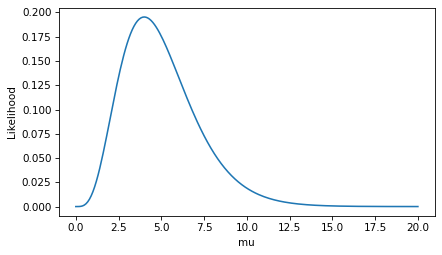

In [9]:
plt.plot(mus, ls)
decorate(xlabel='mu', ylabel='Likelihood')

To find the value of `mu` that maximizes the likelihood of the data, we can use `argmax` to find the index of the highest value in `ls`, and then look up the corresponding element of `mus`.

In [10]:
i = np.argmax(ls)
mus[i]

4.0

In this case, the maximum likelihood estimator is equal to the number of goals we observed.

That's the answer to the estimation problem, but now let's look more closely at those likelihoods.
Here's the likelihood at the maximum of the likelihood function.

In [11]:
np.max(ls)

0.19536681481316454

This likelihood is a probability mass -- specifically, it is the probability of scoring 4 goals, given that the goal-scoring rate is exactly 4.0.

In [12]:
poisson.pmf(4, mu=4)

0.19536681481316454

So, some likelihoods are probability masses -- but not all.

## Density

Now suppose, again, that we know the goal scoring rate is exactly 3,
but now we want to know how long it will be until the next goal.
If we model goal scoring as a Poisson process, the time until the next goal follows an exponential distribution with a rate parameter, `lam=3`.

Because the exponential distribution is continuous, it has a probability density function (PDF) rather than a probability mass function (PMF).
We can approximate the distribution by evaluating the exponential PDF at a set of equally-spaced times, `ts`.

SciPy's implementation of the exponential distribution does not take `lam` as a parameter, so we have to set `scale=1/lam`.

In [13]:
from scipy.stats import expon

lam = 3.0
ts = np.linspace(0, 2.5, 201)
ps = expon.pdf(ts, scale=1/lam)

The PDF is a function of `t` with `lam` as a fixed parameter.
Here's what it looks like.

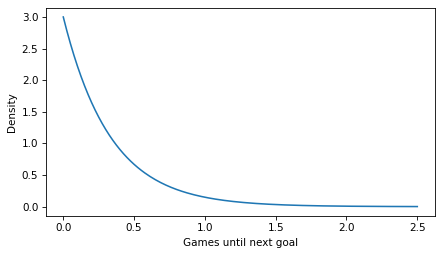

In [14]:
plt.plot(ts, ps)
decorate(xlabel='Games until next goal', ylabel='Density')

Notice that the values on the y-axis extend above 1. That would not be possible if they were probability masses, but it is possible because they are probability densities.

By themselves, probability densities are hard to interpret.
As an example, we can pick an arbitrary element from `ts` and the corresponding element from `ps`.

In [15]:
ts[40], ps[40]

(0.5, 0.6693904804452895)

So the probability density at `t=0.5` is about 0.67. What does that mean? Not much.

To get something meaningful, we have to compute an area under the PDF.
For example, if we want to know the probability that the first goal is scored during the first half of a game, we can compute the area under the curve from `t=0` to `t=0.5`.

We can use a slice index to select the elements of `ps` and `ts` in this interval, and NumPy's `trapz` function, which uses the trapezoid method to compute the area under the curve.

In [16]:
np.trapz(ps[:41], ts[:41])

0.7769608771522626

The probability of a goal in the first half of the game is about 78%.
To check that we got the right answer, we can compute the same probability using the exponential CDF.

In [17]:
expon.cdf(0.5, scale=1/lam)

0.7768698398515702

Considering that we used a discrete approximation of the PDF, our estimate is pretty close.

This example provides an operational definition of a probability density: it's something you can add up over an interval -- or integrate -- to get a probability mass.

## Likelihood and Density

Now let's suppose that we don't know the parameter `lam` and we want to use data to estimate it.
And suppose we observe a game where the first goal is scored at `t=0.5`.
As we did when we estimated the parameter `mu` of the Poisson distribution, we can find the value of `lam` that maximizes the likelihood of this data.

First we'll define a range of possible values of `lam`.

In [18]:
lams = np.linspace(0, 20, 201)

Then for each value of `lam`, we can evaluate the exponential PDF at the observed time `t=0.5` -- using `errstate` to ignore the "division by zero" warning when `lam` is 0.

In [19]:
t = 0.5

with np.errstate(divide='ignore'):
    ls = expon.pdf(t, scale=1/lams)

The result is a likelihood function, which is a function of `lam` with a fixed values of `t`.
Here's what it looks like.

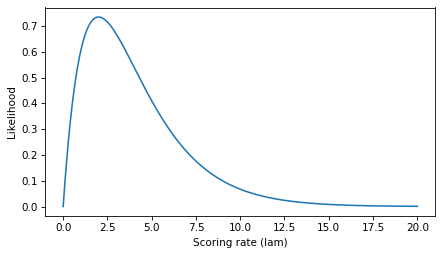

In [20]:
plt.plot(lams, ls)
decorate(xlabel='Scoring rate (lam)', ylabel='Likelihood')

Again, we can use `argmax` to find the index where the value of `ls` is maximized, and look up the corresponding value of `lams`.

In [21]:
i = np.argmax(ls)
lams[i]

2.0

If the first goal is scored at `t=0.5`, the value of `lam` that maximizes the likelihood of this observation is 2.

Now let's look more closely at those likelihoods.
If we select the corresponding element of `ls`, the result is a probability density.

In [22]:
ls[i]

0.7357588823428847

Specifically, it's the value of the exponential PDF with parameter 2, evaluated at `t=0.5`.

In [23]:
expon.pdf(0.5, scale=1/2)

0.7357588823428847

So, some likelihoods are probability densities -- but as we've already seen, not all.

## Discussion

What have we learned?

* In the first example, we evaluated a Poisson PMF at discrete values of `k` with a fixed parameter, `mu`. The results were probability masses.

* In the second example, we evaluated the same PMF for possible values of a parameter, `mu`, with a fixed value of `k`. The result was a likelihood function where each point is a probability mass.

* In the third example, we evaluated an exponential PDF at possible values of `t` with a fixed parameter, `lam`. The results were probability densities, which we integrated over an interval to get a probability mass.

* In the fourth example, we evaluated the same PDF at possible values of a parameter, `lam`, with a fixed value of `t`. The result was a likelihood function where each point is a probability density.

A PDF is a function of an outcome -- like the number of goals scored or the time under the first goal -- given a fixed parameter.
If you evaluate a PDF, you get a probability density.
If you integrate density over an interval, you get a probability mass.

A likelihood function is a function of a parameter, given a fixed outcome.
If you evaluate a likelihood function, you might get a probability mass or a density, depending on whether the outcome is discrete or continuous.
Either way, evaluating a likelihood function at a single point doesn't mean much by itself.
A common use of a likelihood function is finding a maximum likelihood estimator.

As OP says, "Probability density and likelihood are not the same thing", but the distinction is not clear because they are not completely distinct things, either.

* A probability density can be a likelihood, but not all densities are likelihoods.

* A likelihood can be a probability density, but not all likelihoods are densities.

I hope that helps!

### Technical Note

In the scenarios so far, we have observed a single outcome -- the number of goals in a single game or the time until the first goal.
So we've computed likelihoods by evaluating a PMF or PDF at a single point, and the result has been either a probability mass or a density.

More generally, if a dataset has more than one observation, and the observations are independent, we compute a likelihood function for each observation and then multiply them together.
In that case, the product is neither a probability mass or a density.

And there are other cases where it is computationally efficient to compute likelihoods that are *proportional* to probability masses or densities, but not actually either one.

So a likelihood can be a probability mass or a density, but it can also be neither.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)